# Part A
You should only need to run this once, after that can simply load in the saved images as done in part B.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps

Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os
import sys
# import javabridge
# import bioformats

script_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = os.path.abspath(os.path.join(script_dir, "..", "..", "data_processed"))
dir_path = os.path.abspath(
    os.path.join(
        script_dir,
        "..",
        "..",
        "data_raw_big/Xenium_V1_FF_Mouse_Brain_MultiSection_1_outs",
    )
)
file_path = os.path.join(data_dir, "morphology_focus.tif")

In [2]:
%matplotlib widget

# Open the .tif file
img = Image.open(os.path.join(data_dir, "morphology_focus.tif"))
# img = Image.open(os.path.join(dir_path, "morphology_focus.tif"))


# Specify file paths
tif_file_path = "../data_processed/morphology_focus.tif"
ome_tif_file_path = "../data_raw/morphology_focus.ome.tif"

# # Check if the TIFF file already exists
# if not os.path.exists(tif_file_path):
#     # Start the JVM with additional memory
#     javabridge.start_vm(class_path=bioformats.JARS, max_heap_size="10G")

#     try:
#         # Read the OME-TIFF image
#         with bioformats.ImageReader(ome_tif_file_path) as reader:
#             img = reader.read()

#         # Normalize the image if necessary
#         img = img / 255.0  # Normalization, if needed

#         # Convert to PIL image and save as TIFF
#         pil_img = Image.fromarray((img * 255).astype("uint8"))  # Convert to 8-bit unsigned int
#         pil_img.save(tif_file_path, format="TIFF")

#     finally:
#         # Stop the JVM
#         javabridge.kill_vm()


# Convert to numpy array
image_array = np.array(img)

# Calculate the quantile to scale intensity
quantile_value = np.quantile(image_array, 0.99)

# Scale intensity by dividing by the quantile
scaled_image_array = image_array / quantile_value

# Clip values greater than 1 to ensure image is within [0, 1] range
img2 = np.clip(scaled_image_array, 0, 1)

# Display the scaled image
# plt.imshow(img2, cmap='gray')  # Uncomment this line and below to display the whole image (this runs slow)
# plt.show()

In [3]:
cell_boundaries = pd.read_csv(os.path.join(data_dir, "cell_boundaries.csv.gz"))
cell_boundaries["vertex_x_trans"] = cell_boundaries["vertex_x"].apply(
    lambda x: int(x / 0.2125)
)
cell_boundaries["vertex_y_trans"] = cell_boundaries["vertex_y"].apply(
    lambda x: int(x / 0.2125)
)

In [4]:
clusters = pd.read_csv(os.path.join(data_dir, "clusters.csv"))
ncells = clusters.shape[0]
ncells

36553

In [5]:
img_pix = np.array(img)

In [6]:
random.seed(2024)

ncells_subset = 1000

cells_subset = random.sample(range(ncells), ncells_subset)

clusters.loc[cells_subset, "Cluster"]

for i in range(
    1, ncells
):  # change range(1, ncells) to cells_subset (or the other way around) if you want a sample of 1000 images
    # extract the boundary vertices for the selected cell
    bounds_i = cell_boundaries.loc[cell_boundaries["cell_id"] == i]

    # extract the cluster value for the selected cell
    clustval_i = clusters.loc[i, "Cluster"]

    # extract the pixel intensities for the area covering the cell boundary
    img_sub = img_pix[
        min(bounds_i["vertex_y_trans"]) : max(bounds_i["vertex_y_trans"]),
        min(bounds_i["vertex_x_trans"]) : max(bounds_i["vertex_x_trans"]),
    ]

    # normalise the pixel intensities according to 99th percentile
    img_sub_norm = img_sub / np.quantile(img_sub, 0.99)

    # as an example, display the image for the first selected cell
    # if i in cells_subset[0:5]:
    #     print(f"Displaying image for cell {i}")
    # plt.imshow(img_sub_norm, cmap="gray")  # Uncomment this line and below to display sample cell images
    # plt.show()

    # create directory for images if it doesn't exist
    cell_dir = os.path.join(os.getcwd(), data_dir, "cell_images_py")
    if not os.path.exists(cell_dir):
        os.mkdir(cell_dir)

    # create directory for cluster if it doesn't exist
    clust_dir = os.path.join(cell_dir, f"cluster_{clustval_i}")
    if not os.path.exists(clust_dir):
        os.mkdir(clust_dir)

    # save extracted image as a png file
    plt.imsave(os.path.join(clust_dir, f"cell_{i}.png"), img_sub_norm, cmap="gray")

# Part B

### Setup

In [1]:
import matplotlib.pyplot as plt

from PIL import Image, ImageOps

Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import numpy as np


import os
import re


script_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = os.path.abspath(os.path.join(script_dir, "..", "..", "data_processed"))
dir_path = os.path.abspath(
    os.path.join(
        script_dir,
        "..",
        "..",
        "data_raw_big/Xenium_V1_FF_Mouse_Brain_MultiSection_1_outs",
    )
)
file_path = os.path.join(data_dir, "morphology_focus.tif")

In [2]:
DATA_DIRECTORY = data_dir
CELL_IMAGES = os.path.join(DATA_DIRECTORY, "cell_images_py")
SIZE = (50, 50)

## Loading in and displaying images

In [3]:
def get_cluster_images(cluster: int, size=(None, None)):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    files.sort()
    return [
        Image.open(file).convert("L")
        if None in size
        else Image.open(file).convert("L").resize(size)
        for file in files
    ]

In [4]:
def display_images_in_grid(images, ncols=3, cmap=None):
    nrows = (len(images) + ncols - 1) // ncols
    fig_height = (
        nrows * 1
    )  # Adjust the multiplier as needed to control spacing between rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, fig_height))

    for ax in axes.flat:
        ax.axis("off")

    for i, image in enumerate(images):
        ax = axes[i // ncols, i % ncols]
        if not cmap:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap=cmap)

    plt.subplots_adjust(wspace=0.01, hspace=0.03)  # Adjust spacing between subplots
    plt.show()


# display_images_in_grid(cluster_A_images_resized, ncols=10, cmap="gray")

## Cell boundary and masking

### Setup

In [5]:
from shapely.geometry import Polygon
import rasterio
from rasterio.features import geometry_mask
from skimage.draw import polygon2mask

In [6]:
cell_boundaries_raw = pd.read_csv("../../data_processed/cell_boundaries.csv.gz")


def get_cluster_cell_ids(cluster: int):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    pattern = r"cell_(\d+)\.png"
    return [int(re.search(pattern, file).group(1)) for file in files]

In [7]:
def get_masked_image(
    image: Image, cell_id: int, cell_boundaries: pd.core.frame.DataFrame
):
    height, width = np.array(image).shape
    cell_boundary = cell_boundaries[cell_boundaries["cell_id"] == cell_id].copy()
    cell_boundary["vertex_x_scaled"] = 1 + (
        (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min()) * scaling_factor
    )
    cell_boundary["vertex_y_scaled"] = 1 + (
        (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min()) * scaling_factor
    )
    polygon = np.array(
        list(zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"]))
    )
    mask = polygon2mask((height, width), polygon)
    masked_image = np.ma.masked_array(np.copy(image), np.invert(mask), fill_value=0)
    return masked_image


### Masking all cells

In [8]:
def get_cluster_masked_images(cluster: int, size=(None, None), masked=False):
    images = get_cluster_images(cluster)
    if None not in size:  # get resized images if size is specified
        images_resized = get_cluster_images(cluster, size)

    cell_ids = get_cluster_cell_ids(cluster)
    cell_boundaries = cell_boundaries_raw.loc[
        cell_boundaries_raw["cell_id"].isin(cell_ids)
    ].copy()

    # Calculate scaling factor
    scaling_factor = 1 / 0.22

    result = {}
    for cell_id, image, image_resized in zip(cell_ids, images, images_resized):
        if masked:
            # get shape of original image (without resize)
            height, width = np.array(image).shape
            # scaling factor for cell boundary, only if size is given
            resize_x = 50 / width if None not in size else 1
            resize_y = 50 / height if None not in size else 1

            # get cell boundary coordinates for the image
            cell_boundary = cell_boundaries.loc[
                cell_boundaries["cell_id"] == cell_id
            ].copy()
            # Calculate scaled x and y coordinates
            cell_boundary["vertex_x_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
                    * scaling_factor
                )
            ) * resize_x
            cell_boundary["vertex_y_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
                    * scaling_factor
                )
            ) * resize_y

            # create the mask
            polygon = np.array(
                list(
                    zip(
                        cell_boundary["vertex_y_scaled"],
                        cell_boundary["vertex_x_scaled"],
                    )
                )
            )
            mask = polygon2mask((height, width) if None in size else SIZE, polygon)
            # mask the image
            masked_image = np.ma.masked_array(
                np.copy(image if None in size else image_resized),
                np.invert(mask),
                fill_value=0,
            )
            result[cell_id] = np.where(masked_image.mask, 0, masked_image)
        else:
            result[cell_id] = np.copy(image if None in size else image_resized)

    return result

In [10]:
scaling_factor = 1 / 0.22


masked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=True)
    for cluster in range(1, 29)
}

unmasked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=False)
    for cluster in range(1, 29)
}

## Deep Learning

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

### Make the dataset

In [12]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, images_dict, transform=None):
        self.images_dict = images_dict
        self.labels = []
        self.images = []
        for cluster, images in images_dict.items():
            self.images.extend(images.values())
            self.labels.extend([cluster - 1] * len(images))
        self.transform = transform  # Transformation to apply to each image

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert image to PyTorch tensor and normalize if necessary
        image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
        image_tensor = torch.unsqueeze(image_tensor, 0)
        if self.transform:
            image_tensor = self.transform(image_tensor)  # Apply transformation
        # Convert label to PyTorch tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image_tensor, label_tensor

#### Load data and create dataloaders

In [13]:
from torchvision import transforms
from torchvision.transforms import AutoAugmentPolicy

train_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.AutoAugment(AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5], [0.5]
        ),  # Example normalization, adjust as necessary
    ]
)

# Pass these transformations when creating the dataset instance

custom_dataset = CustomDataset(unmasked_cells, train_transforms)
# Define the sizes of the training, validation, and testing sets
train_size = int(0.6 * len(custom_dataset))  # 60% for training
val_size = int(0.2 * len(custom_dataset))  # 20% for validation
test_size = len(custom_dataset) - train_size - val_size  # Remaining for testing

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(
    custom_dataset, [train_size, val_size, test_size]
)

# Define batch size and other DataLoader parameters
batch_size = 32
shuffle = True

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for testing set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Make the models

In [14]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define a modified Vision Transformer (ViT) with a dropout layer
class ModifiedViT(nn.Module):
    def __init__(
        self,
        model_name="vit_base_patch16_224",
        pretrained=True,
        num_classes=1000,
        dropout_rate=0.3,  # Default dropout rate
    ):
        super(ModifiedViT, self).__init__()

        # Load the pretrained ViT model
        self.vit = timm.create_model(
            model_name, pretrained=pretrained, num_classes=num_classes
        )

        # Modify the patch embedding to handle grayscale images
        original_patch_embedding = self.vit.patch_embed.proj
        self.vit.patch_embed.proj = nn.Conv2d(
            1,
            original_patch_embedding.out_channels,
            kernel_size=original_patch_embedding.kernel_size,
            stride=original_patch_embedding.stride,
            padding=original_patch_embedding.padding,
            bias=False,
        )

        # If using pretrained weights, adjust for grayscale
        if pretrained:
            with torch.no_grad():
                original_weight = original_patch_embedding.weight.mean(
                    dim=1, keepdim=True
                )
                self.vit.patch_embed.proj.weight.data = original_weight

        # Add dropout layer after patch embedding
        self.dropout = nn.Dropout(p=dropout_rate)

        # Replace the classifier head
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        x = self.vit.patch_embed(x)

        cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Apply positional dropout and add positional embedding
        x = self.vit.pos_drop(x + self.vit.pos_embed)

        # Apply dropout before entering transformer blocks
        x = self.dropout(x)

        # Forward through the transformer blocks
        x = self.vit.blocks(x)

        # Apply normalization
        x = self.vit.norm(x)

        # Select CLS token and apply final dropout
        x = self.dropout(x[:, 0])

        # Final classifier head
        x = self.vit.head(x)

        return x

### Train

In [15]:
from tqdm import tqdm
import torch
import torch.nn as nn


def train_model(
    model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, save_path=None
):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.clear_autocast_cache()
    model.to(device)

    # Store training and validation loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Progress bar for inner training loop
        with tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False
        ) as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass and backward pass with optimization
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Accumulate loss and accuracy
                running_train_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Update the progress bar with training loss and accuracy
                pbar.set_postfix(
                    {
                        "train_loss": running_train_loss / total_train,
                        "accuracy": correct_train / total_train,
                    }
                )

        # Calculate average training loss and accuracy for the epoch
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate loss and accuracy
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # Save the model state
        if save_path:
            model_save_path = os.path.join(save_path, f"model_epoch_{epoch + 1}.pth")
            torch.save(model.state_dict(), model_save_path)

        # Optional: Print a summary at the end of each epoch
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, "
            f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}"
        )

    # Return training and validation losses and accuracies
    return train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
for images, labels in train_loader:
    print(images.size())
    break

torch.Size([32, 1, 224, 224])


In [17]:
from torch import device, Tensor
import torchvision.models as models


# Load the pre-trained ResNet model
torch.cuda.empty_cache()
model = ModifiedViT()

t_loss, v_loss, t_acc, v_acc = train_model(
    model, train_loader, val_loader, num_epochs=200
)
lab_model_results = {"t_loss": t_loss, "v_loss": v_loss, "t_acc": t_acc, "v_acc": v_acc}

Epoch [1/200], Train Loss: 3.3567, Train Accuracy: 0.0746, Val Loss: 3.1921, Val Accuracy: 0.0906


Epoch [2/200], Train Loss: 3.1500, Train Accuracy: 0.0950, Val Loss: 3.1481, Val Accuracy: 0.0837


Epoch [3/200], Train Loss: 3.1132, Train Accuracy: 0.1010, Val Loss: 3.0945, Val Accuracy: 0.1033


Epoch [4/200], Train Loss: 3.1061, Train Accuracy: 0.0996, Val Loss: 3.0867, Val Accuracy: 0.0982


Epoch [5/200], Train Loss: 3.0961, Train Accuracy: 0.1037, Val Loss: 3.1043, Val Accuracy: 0.0999


Epoch [6/200], Train Loss: 3.0952, Train Accuracy: 0.1038, Val Loss: 3.0805, Val Accuracy: 0.1051


Epoch [7/200], Train Loss: 3.0977, Train Accuracy: 0.1008, Val Loss: 3.0886, Val Accuracy: 0.1096


Epoch [8/200], Train Loss: 3.1006, Train Accuracy: 0.0985, Val Loss: 3.0918, Val Accuracy: 0.0986


Epoch [9/200], Train Loss: 3.0921, Train Accuracy: 0.1026, Val Loss: 3.0939, Val Accuracy: 0.0896


Epoch [10/200], Train Loss: 3.1007, Train Accuracy: 0.1015, Val Loss: 3.1047, Val Accuracy: 0.0892


Epoch [11/200], Train Loss: 3.0960, Train Accuracy: 0.0993, Val Loss: 3.0969, Val Accuracy: 0.1060


Epoch [12/200], Train Loss: 3.0955, Train Accuracy: 0.1038, Val Loss: 3.1032, Val Accuracy: 0.1053


Epoch [13/200], Train Loss: 3.1058, Train Accuracy: 0.0975, Val Loss: 3.2028, Val Accuracy: 0.0818


Epoch [14/200], Train Loss: 3.0999, Train Accuracy: 0.1015, Val Loss: 3.0863, Val Accuracy: 0.1089


Epoch [15/200], Train Loss: 3.1000, Train Accuracy: 0.1022, Val Loss: 3.0898, Val Accuracy: 0.1045


Epoch [16/200], Train Loss: 3.1039, Train Accuracy: 0.0980, Val Loss: 3.0819, Val Accuracy: 0.1064


Epoch [17/200], Train Loss: 3.0936, Train Accuracy: 0.1026, Val Loss: 3.0807, Val Accuracy: 0.1060


Epoch [18/200], Train Loss: 3.0899, Train Accuracy: 0.1016, Val Loss: 3.0836, Val Accuracy: 0.1057


Epoch [19/200], Train Loss: 3.0895, Train Accuracy: 0.0998, Val Loss: 3.1171, Val Accuracy: 0.1008


Epoch [20/200], Train Loss: 3.1006, Train Accuracy: 0.0988, Val Loss: 3.1420, Val Accuracy: 0.0933


Epoch [21/200], Train Loss: 3.1294, Train Accuracy: 0.0940, Val Loss: 3.0968, Val Accuracy: 0.0970


Epoch [22/200], Train Loss: 3.1089, Train Accuracy: 0.0968, Val Loss: 3.1129, Val Accuracy: 0.1081


Epoch [23/200], Train Loss: 3.1041, Train Accuracy: 0.0996, Val Loss: 3.0988, Val Accuracy: 0.1012


Epoch [24/200], Train Loss: 3.0992, Train Accuracy: 0.0991, Val Loss: 3.1088, Val Accuracy: 0.1055


Epoch [25/200], Train Loss: 3.0987, Train Accuracy: 0.0977, Val Loss: 3.1097, Val Accuracy: 0.1066


Epoch [26/200], Train Loss: 3.1165, Train Accuracy: 0.0984, Val Loss: 3.1298, Val Accuracy: 0.0962


Epoch [27/200], Train Loss: 3.1134, Train Accuracy: 0.0957, Val Loss: 3.1119, Val Accuracy: 0.0992


Epoch [28/200], Train Loss: 3.1053, Train Accuracy: 0.0995, Val Loss: 3.0915, Val Accuracy: 0.0989


Epoch [29/200], Train Loss: 3.0967, Train Accuracy: 0.0997, Val Loss: 3.0864, Val Accuracy: 0.1055


Epoch [30/200], Train Loss: 3.0981, Train Accuracy: 0.1000, Val Loss: 3.0977, Val Accuracy: 0.0977


Epoch [31/200], Train Loss: 3.0944, Train Accuracy: 0.1020, Val Loss: 3.0931, Val Accuracy: 0.1060


Epoch [32/200], Train Loss: 3.1073, Train Accuracy: 0.0966, Val Loss: 3.0932, Val Accuracy: 0.0993


Epoch [33/200], Train Loss: 3.1039, Train Accuracy: 0.0995, Val Loss: 3.1140, Val Accuracy: 0.0955


Epoch [34/200], Train Loss: 3.1137, Train Accuracy: 0.0960, Val Loss: 3.0970, Val Accuracy: 0.1048


Epoch [35/200], Train Loss: 3.1045, Train Accuracy: 0.0975, Val Loss: 3.0889, Val Accuracy: 0.1071


Epoch [36/200], Train Loss: 3.1006, Train Accuracy: 0.0995, Val Loss: 3.0921, Val Accuracy: 0.0959


Epoch [37/200], Train Loss: 3.0989, Train Accuracy: 0.0982, Val Loss: 3.0884, Val Accuracy: 0.1078


Epoch [38/200], Train Loss: 3.1011, Train Accuracy: 0.0989, Val Loss: 3.1000, Val Accuracy: 0.1030


Epoch [39/200], Train Loss: 3.0978, Train Accuracy: 0.0979, Val Loss: 3.0947, Val Accuracy: 0.0981


Epoch [40/200], Train Loss: 3.0956, Train Accuracy: 0.0982, Val Loss: 3.0934, Val Accuracy: 0.1019


Epoch [41/200], Train Loss: 3.1024, Train Accuracy: 0.0993, Val Loss: 3.1184, Val Accuracy: 0.0888


Epoch [42/200], Train Loss: 3.1251, Train Accuracy: 0.0953, Val Loss: 3.1477, Val Accuracy: 0.0834


Epoch [43/200], Train Loss: 3.1269, Train Accuracy: 0.0925, Val Loss: 3.1329, Val Accuracy: 0.0912


Epoch [44/200], Train Loss: 3.1307, Train Accuracy: 0.0891, Val Loss: 3.1329, Val Accuracy: 0.0803


Epoch [45/200], Train Loss: 3.1248, Train Accuracy: 0.0939, Val Loss: 3.1196, Val Accuracy: 0.0969


Epoch [46/200], Train Loss: 3.1307, Train Accuracy: 0.0895, Val Loss: 3.1385, Val Accuracy: 0.0888


Epoch [47/200], Train Loss: 3.1199, Train Accuracy: 0.0942, Val Loss: 3.1054, Val Accuracy: 0.0944


Epoch [48/200], Train Loss: 3.1150, Train Accuracy: 0.0941, Val Loss: 3.1052, Val Accuracy: 0.0999


Epoch [49/200], Train Loss: 3.1094, Train Accuracy: 0.0955, Val Loss: 3.1229, Val Accuracy: 0.0881


Epoch [50/200], Train Loss: 3.1093, Train Accuracy: 0.0957, Val Loss: 3.1043, Val Accuracy: 0.1078


Epoch [51/200], Train Loss: 3.1069, Train Accuracy: 0.0986, Val Loss: 3.0956, Val Accuracy: 0.1051


Epoch [52/200], Train Loss: 3.1197, Train Accuracy: 0.0948, Val Loss: 3.1322, Val Accuracy: 0.0899


Epoch [53/200], Train Loss: 3.1177, Train Accuracy: 0.0962, Val Loss: 3.1100, Val Accuracy: 0.0953


Epoch [54/200], Train Loss: 3.1165, Train Accuracy: 0.0943, Val Loss: 3.1064, Val Accuracy: 0.0997


Epoch [55/200], Train Loss: 3.1058, Train Accuracy: 0.0994, Val Loss: 3.1045, Val Accuracy: 0.1005


Epoch [56/200], Train Loss: 3.1027, Train Accuracy: 0.0983, Val Loss: 3.1058, Val Accuracy: 0.1010


Epoch [57/200], Train Loss: 3.1013, Train Accuracy: 0.0986, Val Loss: 3.1063, Val Accuracy: 0.0963


Epoch [58/200], Train Loss: 3.0998, Train Accuracy: 0.1001, Val Loss: 3.0893, Val Accuracy: 0.0993


Epoch [59/200], Train Loss: 3.0957, Train Accuracy: 0.0982, Val Loss: 3.0882, Val Accuracy: 0.1005


Epoch [60/200], Train Loss: 3.1056, Train Accuracy: 0.0994, Val Loss: 3.1153, Val Accuracy: 0.0941


Epoch [61/200], Train Loss: 3.1187, Train Accuracy: 0.0940, Val Loss: 3.1361, Val Accuracy: 0.0915


Epoch [62/200], Train Loss: 3.1119, Train Accuracy: 0.0967, Val Loss: 3.1018, Val Accuracy: 0.0958


Epoch [63/200], Train Loss: 3.1044, Train Accuracy: 0.0972, Val Loss: 3.1121, Val Accuracy: 0.0949


Epoch [64/200], Train Loss: 3.1033, Train Accuracy: 0.0968, Val Loss: 3.0998, Val Accuracy: 0.1004


Epoch [65/200], Train Loss: 3.1064, Train Accuracy: 0.0977, Val Loss: 3.1108, Val Accuracy: 0.1004


Epoch [66/200], Train Loss: 3.1107, Train Accuracy: 0.0978, Val Loss: 3.1281, Val Accuracy: 0.0977


Epoch [67/200], Train Loss: 3.1027, Train Accuracy: 0.0976, Val Loss: 3.0926, Val Accuracy: 0.1027


Epoch [68/200], Train Loss: 3.1101, Train Accuracy: 0.0978, Val Loss: 3.0988, Val Accuracy: 0.0973


Epoch [69/200], Train Loss: 3.1003, Train Accuracy: 0.1016, Val Loss: 3.0949, Val Accuracy: 0.1011


Epoch [70/200], Train Loss: 3.0995, Train Accuracy: 0.0991, Val Loss: 3.0957, Val Accuracy: 0.0993


Epoch [71/200], Train Loss: 3.0971, Train Accuracy: 0.1009, Val Loss: 3.1143, Val Accuracy: 0.0981


Epoch [72/200], Train Loss: 3.1037, Train Accuracy: 0.0984, Val Loss: 3.0941, Val Accuracy: 0.0969


Epoch [73/200], Train Loss: 3.0957, Train Accuracy: 0.1011, Val Loss: 3.1028, Val Accuracy: 0.0985


Epoch [74/200], Train Loss: 3.1058, Train Accuracy: 0.0997, Val Loss: 3.1111, Val Accuracy: 0.0903


Epoch [75/200], Train Loss: 3.1145, Train Accuracy: 0.0957, Val Loss: 3.0982, Val Accuracy: 0.1027


Epoch [76/200], Train Loss: 3.1038, Train Accuracy: 0.0989, Val Loss: 3.1021, Val Accuracy: 0.0911


Epoch [77/200], Train Loss: 3.1360, Train Accuracy: 0.0893, Val Loss: 3.1233, Val Accuracy: 0.0949


Epoch [78/200], Train Loss: 3.1202, Train Accuracy: 0.0952, Val Loss: 3.1212, Val Accuracy: 0.0937


Epoch [79/200], Train Loss: 3.1242, Train Accuracy: 0.0907, Val Loss: 3.1512, Val Accuracy: 0.0810


Epoch [80/200], Train Loss: 3.1232, Train Accuracy: 0.0966, Val Loss: 3.1081, Val Accuracy: 0.0988


Epoch [81/200], Train Loss: 3.1157, Train Accuracy: 0.0937, Val Loss: 3.1238, Val Accuracy: 0.0891


Epoch [82/200], Train Loss: 3.1400, Train Accuracy: 0.0853, Val Loss: 3.1394, Val Accuracy: 0.0858


Epoch [83/200], Train Loss: 3.1420, Train Accuracy: 0.0844, Val Loss: 3.1433, Val Accuracy: 0.0788


Epoch [84/200], Train Loss: 3.1410, Train Accuracy: 0.0831, Val Loss: 3.1432, Val Accuracy: 0.0848


Epoch [85/200], Train Loss: 3.1417, Train Accuracy: 0.0840, Val Loss: 3.1399, Val Accuracy: 0.0799


Epoch [86/200], Train Loss: 3.1398, Train Accuracy: 0.0840, Val Loss: 3.1392, Val Accuracy: 0.0910


Epoch [87/200], Train Loss: 3.1391, Train Accuracy: 0.0844, Val Loss: 3.1438, Val Accuracy: 0.0878


Epoch [88/200], Train Loss: 3.1421, Train Accuracy: 0.0835, Val Loss: 3.1369, Val Accuracy: 0.0822


Epoch [89/200], Train Loss: 3.1413, Train Accuracy: 0.0881, Val Loss: 3.1389, Val Accuracy: 0.0802


Epoch [90/200], Train Loss: 3.1420, Train Accuracy: 0.0830, Val Loss: 3.1382, Val Accuracy: 0.0802


Epoch [91/200], Train Loss: 3.1413, Train Accuracy: 0.0809, Val Loss: 3.1358, Val Accuracy: 0.0810


Epoch [92/200], Train Loss: 3.1405, Train Accuracy: 0.0844, Val Loss: 3.1387, Val Accuracy: 0.0908


Epoch [93/200], Train Loss: 3.1417, Train Accuracy: 0.0858, Val Loss: 3.1364, Val Accuracy: 0.0859


Epoch [94/200], Train Loss: 3.1450, Train Accuracy: 0.0833, Val Loss: 3.1423, Val Accuracy: 0.0917


Epoch [95/200], Train Loss: 3.1406, Train Accuracy: 0.0841, Val Loss: 3.1420, Val Accuracy: 0.0876


Epoch [96/200], Train Loss: 3.1401, Train Accuracy: 0.0875, Val Loss: 3.1468, Val Accuracy: 0.0793


Epoch [97/200], Train Loss: 3.1397, Train Accuracy: 0.0824, Val Loss: 3.1396, Val Accuracy: 0.0792


Epoch [98/200], Train Loss: 3.1415, Train Accuracy: 0.0808, Val Loss: 3.1477, Val Accuracy: 0.0889


Epoch [99/200], Train Loss: 3.1410, Train Accuracy: 0.0838, Val Loss: 3.1398, Val Accuracy: 0.0822


Epoch [100/200], Train Loss: 3.1439, Train Accuracy: 0.0867, Val Loss: 3.1381, Val Accuracy: 0.0795


Epoch [101/200], Train Loss: 3.1395, Train Accuracy: 0.0825, Val Loss: 3.1378, Val Accuracy: 0.0817


Epoch [102/200], Train Loss: 3.1402, Train Accuracy: 0.0839, Val Loss: 3.1390, Val Accuracy: 0.0895


Epoch [103/200], Train Loss: 3.1401, Train Accuracy: 0.0822, Val Loss: 3.1394, Val Accuracy: 0.0873


Epoch [104/200], Train Loss: 3.1402, Train Accuracy: 0.0841, Val Loss: 3.1367, Val Accuracy: 0.0908


Epoch [105/200], Train Loss: 3.1431, Train Accuracy: 0.0810, Val Loss: 3.1378, Val Accuracy: 0.0886


Epoch [106/200], Train Loss: 3.1397, Train Accuracy: 0.0859, Val Loss: 3.1378, Val Accuracy: 0.0888


Epoch [107/200], Train Loss: 3.1554, Train Accuracy: 0.0815, Val Loss: 3.1672, Val Accuracy: 0.0777


Epoch [108/200], Train Loss: 3.1502, Train Accuracy: 0.0818, Val Loss: 3.1444, Val Accuracy: 0.0810


Epoch [109/200], Train Loss: 3.1412, Train Accuracy: 0.0824, Val Loss: 3.1407, Val Accuracy: 0.0813


Epoch [110/200], Train Loss: 3.1420, Train Accuracy: 0.0801, Val Loss: 3.1423, Val Accuracy: 0.0843


Epoch [111/200], Train Loss: 3.1439, Train Accuracy: 0.0849, Val Loss: 3.1357, Val Accuracy: 0.0818


Epoch [112/200], Train Loss: 3.1436, Train Accuracy: 0.0833, Val Loss: 3.1435, Val Accuracy: 0.0804


Epoch [113/200], Train Loss: 3.1409, Train Accuracy: 0.0838, Val Loss: 3.1397, Val Accuracy: 0.0810


Epoch [114/200], Train Loss: 3.1401, Train Accuracy: 0.0838, Val Loss: 3.1455, Val Accuracy: 0.0793


Epoch [115/200], Train Loss: 3.1422, Train Accuracy: 0.0842, Val Loss: 3.1493, Val Accuracy: 0.0778


Epoch [116/200], Train Loss: 3.1406, Train Accuracy: 0.0833, Val Loss: 3.1425, Val Accuracy: 0.0792


Epoch [117/200], Train Loss: 3.1421, Train Accuracy: 0.0820, Val Loss: 3.1344, Val Accuracy: 0.0793


Epoch [118/200], Train Loss: 3.1359, Train Accuracy: 0.0840, Val Loss: 3.1325, Val Accuracy: 0.0912


Epoch [119/200], Train Loss: 3.1345, Train Accuracy: 0.0846, Val Loss: 3.1340, Val Accuracy: 0.0867


Epoch [120/200], Train Loss: 3.1341, Train Accuracy: 0.0884, Val Loss: 3.1399, Val Accuracy: 0.0878


Epoch [121/200], Train Loss: 3.1362, Train Accuracy: 0.0916, Val Loss: 3.1285, Val Accuracy: 0.0926


Epoch [122/200], Train Loss: 3.1388, Train Accuracy: 0.0880, Val Loss: 3.1349, Val Accuracy: 0.0866


Epoch [123/200], Train Loss: 3.1268, Train Accuracy: 0.0939, Val Loss: 3.1561, Val Accuracy: 0.0895


Epoch [124/200], Train Loss: 3.1395, Train Accuracy: 0.0866, Val Loss: 3.1247, Val Accuracy: 0.0911


Epoch [125/200], Train Loss: 3.1255, Train Accuracy: 0.0913, Val Loss: 3.1185, Val Accuracy: 0.0907


Epoch [126/200], Train Loss: 3.1275, Train Accuracy: 0.0886, Val Loss: 3.1237, Val Accuracy: 0.0934


Epoch [127/200], Train Loss: 3.1377, Train Accuracy: 0.0869, Val Loss: 3.1464, Val Accuracy: 0.0897


Epoch [128/200], Train Loss: 3.1361, Train Accuracy: 0.0854, Val Loss: 3.1399, Val Accuracy: 0.0895


Epoch [129/200], Train Loss: 3.1408, Train Accuracy: 0.0827, Val Loss: 3.1331, Val Accuracy: 0.0855


Epoch [130/200], Train Loss: 3.1368, Train Accuracy: 0.0843, Val Loss: 3.1311, Val Accuracy: 0.0884


Epoch [131/200], Train Loss: 3.1341, Train Accuracy: 0.0866, Val Loss: 3.1341, Val Accuracy: 0.0822


Epoch [132/200], Train Loss: 3.1487, Train Accuracy: 0.0844, Val Loss: 3.1439, Val Accuracy: 0.0837


Epoch [133/200], Train Loss: 3.1377, Train Accuracy: 0.0822, Val Loss: 3.1368, Val Accuracy: 0.0824


Epoch [134/200], Train Loss: 3.1425, Train Accuracy: 0.0901, Val Loss: 3.1459, Val Accuracy: 0.0819


Epoch [135/200], Train Loss: 3.1407, Train Accuracy: 0.0807, Val Loss: 3.1313, Val Accuracy: 0.0885


Epoch [136/200], Train Loss: 3.1379, Train Accuracy: 0.0802, Val Loss: 3.1379, Val Accuracy: 0.0828


Epoch [137/200], Train Loss: 3.1344, Train Accuracy: 0.0864, Val Loss: 3.1351, Val Accuracy: 0.0877


Epoch [138/200], Train Loss: 3.1328, Train Accuracy: 0.0827, Val Loss: 3.1343, Val Accuracy: 0.0863


Epoch [139/200], Train Loss: 3.1331, Train Accuracy: 0.0895, Val Loss: 3.1372, Val Accuracy: 0.0874


Epoch [140/200], Train Loss: 3.1326, Train Accuracy: 0.0864, Val Loss: 3.1325, Val Accuracy: 0.0907


Epoch [141/200], Train Loss: 3.1310, Train Accuracy: 0.0897, Val Loss: 3.1310, Val Accuracy: 0.0955


Epoch [142/200], Train Loss: 3.1316, Train Accuracy: 0.0868, Val Loss: 3.1435, Val Accuracy: 0.0810


Epoch [143/200], Train Loss: 3.1358, Train Accuracy: 0.0817, Val Loss: 3.1320, Val Accuracy: 0.0891


Epoch [144/200], Train Loss: 3.1301, Train Accuracy: 0.0874, Val Loss: 3.1263, Val Accuracy: 0.0870


Epoch [145/200], Train Loss: 3.1289, Train Accuracy: 0.0911, Val Loss: 3.1248, Val Accuracy: 0.0949


Epoch [146/200], Train Loss: 3.1316, Train Accuracy: 0.0896, Val Loss: 3.1302, Val Accuracy: 0.0919


Epoch [147/200], Train Loss: 3.1314, Train Accuracy: 0.0886, Val Loss: 3.1329, Val Accuracy: 0.0914


Epoch [148/200], Train Loss: 3.1385, Train Accuracy: 0.0873, Val Loss: 3.1396, Val Accuracy: 0.0799


Epoch [149/200], Train Loss: 3.1392, Train Accuracy: 0.0824, Val Loss: 3.1347, Val Accuracy: 0.0843


Epoch [150/200], Train Loss: 3.1441, Train Accuracy: 0.0861, Val Loss: 3.1366, Val Accuracy: 0.0854


Epoch [151/200], Train Loss: 3.1479, Train Accuracy: 0.0820, Val Loss: 3.1375, Val Accuracy: 0.0880


Epoch [152/200], Train Loss: 3.1378, Train Accuracy: 0.0841, Val Loss: 3.1367, Val Accuracy: 0.0882


Epoch [153/200], Train Loss: 3.1371, Train Accuracy: 0.0864, Val Loss: 3.1347, Val Accuracy: 0.0860


Epoch [154/200], Train Loss: 3.1365, Train Accuracy: 0.0834, Val Loss: 3.1365, Val Accuracy: 0.0841


Epoch [155/200], Train Loss: 3.1376, Train Accuracy: 0.0860, Val Loss: 3.1349, Val Accuracy: 0.0878


Epoch [156/200], Train Loss: 3.1364, Train Accuracy: 0.0846, Val Loss: 3.1343, Val Accuracy: 0.0888


Epoch [157/200], Train Loss: 3.1352, Train Accuracy: 0.0871, Val Loss: 3.1329, Val Accuracy: 0.0860


Epoch [158/200], Train Loss: 3.1372, Train Accuracy: 0.0831, Val Loss: 3.1328, Val Accuracy: 0.0834


Epoch [159/200], Train Loss: 3.1347, Train Accuracy: 0.0843, Val Loss: 3.1365, Val Accuracy: 0.0844


Epoch [160/200], Train Loss: 3.1365, Train Accuracy: 0.0864, Val Loss: 3.1390, Val Accuracy: 0.0793


Epoch [161/200], Train Loss: 3.1371, Train Accuracy: 0.0803, Val Loss: 3.1332, Val Accuracy: 0.0837


Epoch [162/200], Train Loss: 3.1355, Train Accuracy: 0.0854, Val Loss: 3.1355, Val Accuracy: 0.0852


Epoch [163/200], Train Loss: 3.1382, Train Accuracy: 0.0854, Val Loss: 3.1409, Val Accuracy: 0.0811


Epoch [164/200], Train Loss: 3.1364, Train Accuracy: 0.0844, Val Loss: 3.1374, Val Accuracy: 0.0863


Epoch [165/200], Train Loss: 3.1399, Train Accuracy: 0.0845, Val Loss: 3.1418, Val Accuracy: 0.0811


Epoch [166/200], Train Loss: 3.1439, Train Accuracy: 0.0869, Val Loss: 3.1387, Val Accuracy: 0.0886


Epoch [167/200], Train Loss: 3.1498, Train Accuracy: 0.0811, Val Loss: 3.1401, Val Accuracy: 0.0795


Epoch [168/200], Train Loss: 3.1406, Train Accuracy: 0.0826, Val Loss: 3.1431, Val Accuracy: 0.0810


Epoch [169/200], Train Loss: 3.1435, Train Accuracy: 0.0839, Val Loss: 3.1414, Val Accuracy: 0.0793


Epoch [170/200], Train Loss: 3.1436, Train Accuracy: 0.0822, Val Loss: 3.1431, Val Accuracy: 0.0776


Epoch [171/200], Train Loss: 3.1421, Train Accuracy: 0.0825, Val Loss: 3.1389, Val Accuracy: 0.0811


Epoch [172/200], Train Loss: 3.1403, Train Accuracy: 0.0825, Val Loss: 3.1385, Val Accuracy: 0.0877


Epoch [173/200], Train Loss: 3.1413, Train Accuracy: 0.0807, Val Loss: 3.1394, Val Accuracy: 0.0793


Epoch [174/200], Train Loss: 3.1405, Train Accuracy: 0.0824, Val Loss: 3.1408, Val Accuracy: 0.0804


Epoch [175/200], Train Loss: 3.1403, Train Accuracy: 0.0843, Val Loss: 3.1375, Val Accuracy: 0.0810


Epoch [176/200], Train Loss: 3.1402, Train Accuracy: 0.0838, Val Loss: 3.1420, Val Accuracy: 0.0800


Epoch [177/200], Train Loss: 3.1405, Train Accuracy: 0.0831, Val Loss: 3.1406, Val Accuracy: 0.0818


Epoch [178/200], Train Loss: 3.1405, Train Accuracy: 0.0828, Val Loss: 3.1396, Val Accuracy: 0.0884


Epoch [179/200], Train Loss: 3.1406, Train Accuracy: 0.0838, Val Loss: 3.1389, Val Accuracy: 0.0810


Epoch [180/200], Train Loss: 3.1404, Train Accuracy: 0.0850, Val Loss: 3.1375, Val Accuracy: 0.0806


Epoch [181/200], Train Loss: 3.1409, Train Accuracy: 0.0830, Val Loss: 3.1372, Val Accuracy: 0.0810


Epoch [182/200], Train Loss: 3.1398, Train Accuracy: 0.0819, Val Loss: 3.1382, Val Accuracy: 0.0824


Epoch [183/200], Train Loss: 3.1404, Train Accuracy: 0.0839, Val Loss: 3.1382, Val Accuracy: 0.0866


Epoch [184/200], Train Loss: 3.1408, Train Accuracy: 0.0849, Val Loss: 3.1424, Val Accuracy: 0.0852


Epoch [185/200], Train Loss: 3.1402, Train Accuracy: 0.0815, Val Loss: 3.1518, Val Accuracy: 0.0886


Epoch [186/200], Train Loss: 3.1425, Train Accuracy: 0.0819, Val Loss: 3.1430, Val Accuracy: 0.0810


Epoch [187/200], Train Loss: 3.1407, Train Accuracy: 0.0861, Val Loss: 3.1404, Val Accuracy: 0.0893


Epoch [188/200], Train Loss: 3.1407, Train Accuracy: 0.0820, Val Loss: 3.1396, Val Accuracy: 0.0798


Epoch [189/200], Train Loss: 3.1403, Train Accuracy: 0.0849, Val Loss: 3.1406, Val Accuracy: 0.0800


Epoch [190/200], Train Loss: 3.1407, Train Accuracy: 0.0816, Val Loss: 3.1377, Val Accuracy: 0.0884


Epoch [191/200], Train Loss: 3.1403, Train Accuracy: 0.0827, Val Loss: 3.1391, Val Accuracy: 0.0834


Epoch [192/200], Train Loss: 3.1403, Train Accuracy: 0.0840, Val Loss: 3.1394, Val Accuracy: 0.0856


Epoch [193/200], Train Loss: 3.1395, Train Accuracy: 0.0844, Val Loss: 3.1399, Val Accuracy: 0.0793


Epoch [194/200], Train Loss: 3.1394, Train Accuracy: 0.0838, Val Loss: 3.1370, Val Accuracy: 0.0807


Epoch [195/200], Train Loss: 3.1390, Train Accuracy: 0.0811, Val Loss: 3.1431, Val Accuracy: 0.0836


Epoch [196/200], Train Loss: 3.1402, Train Accuracy: 0.0830, Val Loss: 3.1366, Val Accuracy: 0.0886


Epoch [197/200], Train Loss: 3.1403, Train Accuracy: 0.0838, Val Loss: 3.1421, Val Accuracy: 0.0807


Epoch [198/200], Train Loss: 3.1403, Train Accuracy: 0.0830, Val Loss: 3.1401, Val Accuracy: 0.0882


Epoch [199/200], Train Loss: 3.1400, Train Accuracy: 0.0814, Val Loss: 3.1383, Val Accuracy: 0.0788


Epoch [200/200], Train Loss: 3.1396, Train Accuracy: 0.0848, Val Loss: 3.1402, Val Accuracy: 0.0888


In [20]:
# generate_plots(lab_model_results['t_loss'], lab_model_results['v_loss'], lab_model_results['t_acc'], lab_model_results['v_acc'])
def generate_plots(train_losses, val_losses, train_accuracies, val_accuracies):
    with plt.style.context("dark_background"):
        # Generate x-axis values (epochs)
        epochs = range(1, len(train_losses) + 1)

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # Plot training and validation losses
        ax1.plot(epochs, train_losses, label="Training Loss", marker="o")
        ax1.plot(epochs, val_losses, label="Validation Loss", marker="o")

        # Add jitter to the data points for better visualization
        ax1.scatter(epochs, train_losses, color="blue")
        ax1.scatter(epochs, val_losses, color="orange")

        # Add labels and legend for the first subplot
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.set_title("Training and Validation Loss")
        ax1.legend()

        # Plot training and validation accuracies
        ax2.plot(epochs, train_accuracies, label="Training Accuracy", marker="o")
        ax2.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")

        # Add jitter to the data points for better visualization
        ax2.scatter(epochs, train_accuracies, color="green")
        ax2.scatter(epochs, val_accuracies, color="red")

        # Add labels and legend for the second subplot
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.set_title("Training and Validation Accuracy")
        ax2.legend()

        # Adjust layout
        plt.tight_layout()

        # Show plot
        plt.show()

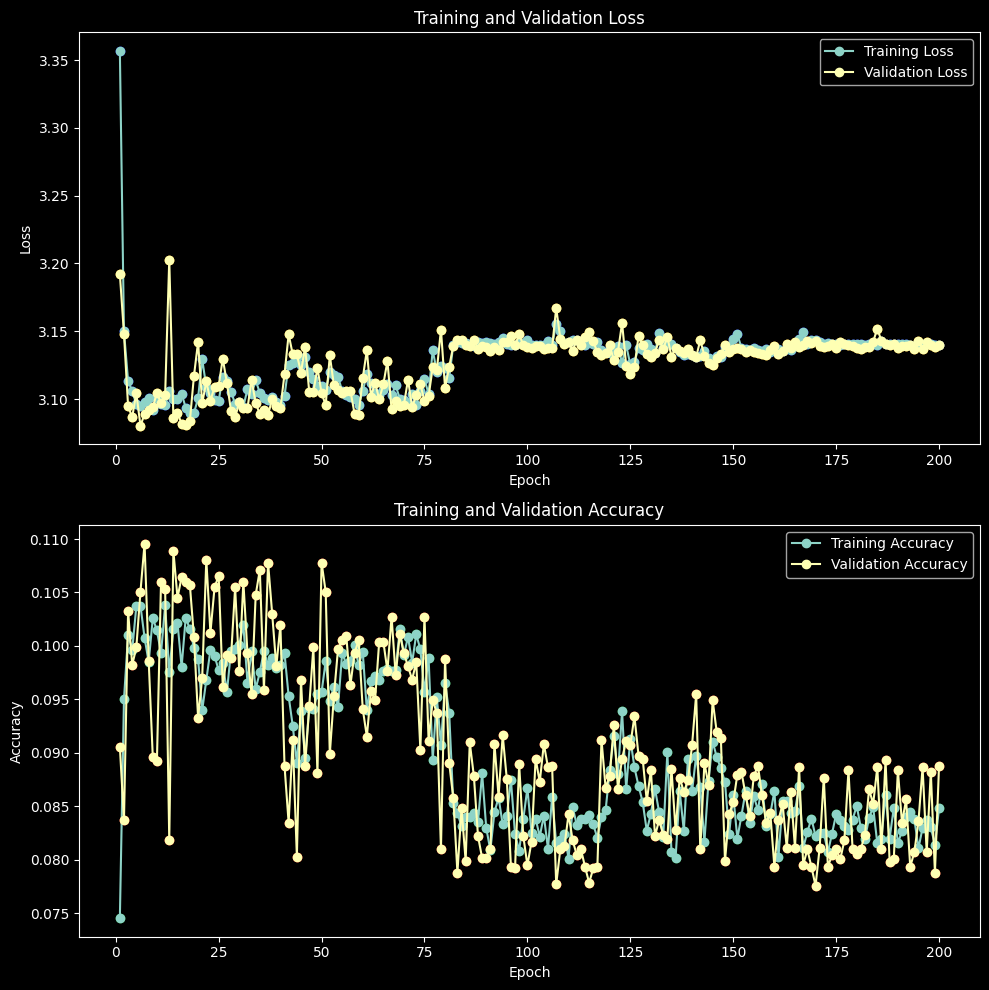

In [21]:
generate_plots(
    lab_model_results["t_loss"],
    lab_model_results["v_loss"],
    lab_model_results["t_acc"],
    lab_model_results["v_acc"],
)